<a href="https://colab.research.google.com/github/taniokah/DL-Basic-Seminar2/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning

VGG16を用いて転移学習を実験します。
対象データは、apple、strawberry、tomato の3種類の画像を用います。


In [1]:
!pip install pillow
!pip install icrawler

In [0]:
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler

bing_crawler = BingImageCrawler(storage={'root_dir': 'images/train/apple'}, downloader_threads=4)
bing_crawler.crawl(keyword='apple', filters=None, offset=0, max_num=1000) 
bing_crawler = BingImageCrawler(storage={'root_dir': 'images/train/strawberry'}, downloader_threads=4)
bing_crawler.crawl(keyword='strawberry', filters=None, offset=0, max_num=1000)
bing_crawler = BingImageCrawler(storage={'root_dir': 'images/train/tomato'}, downloader_threads=4)
bing_crawler.crawl(keyword='tomato', filters=None, offset=0, max_num=1000)


In [0]:
baidu_crawler = BaiduImageCrawler(storage={'root_dir': 'images/validation/apple'}, downloader_threads=4)
baidu_crawler.crawl(keyword='apple', offset=0, max_num=200)
baidu_crawler = BaiduImageCrawler(storage={'root_dir': 'images/validation/strawberry'}, downloader_threads=4)
baidu_crawler.crawl(keyword='strawberry', offset=0, max_num=200)
baidu_crawler = BaiduImageCrawler(storage={'root_dir': 'images/validation/tomato'}, downloader_threads=4)
baidu_crawler.crawl(keyword='tomato', offset=0, max_num=200)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33 bytes but only got 19. Skipping tag 42016
  " Skipping tag %s" % (size, len(data), tag)


62/62 [==============================] - 55s 895ms/step - loss: 1.0742 - acc: 0.3895 - val_loss: 1.0751 - val_acc: 0.4427
Epoch 3/30
 1/62 [..............................] - ETA: 9s - loss: 1.1312 - acc: 0.2500

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


62/62 [==============================] - 47s 753ms/step - loss: 1.0303 - acc: 0.4540 - val_loss: 1.0238 - val_acc: 0.5615
Epoch 4/30
62/62 [==============================] - 45s 730ms/step - loss: 1.0041 - acc: 0.5111 - val_loss: 0.9765 - val_acc: 0.5885
Epoch 5/30
62/62 [==============================] - 46s 735ms/step - loss: 0.9544 - acc: 0.5468 - val_loss: 1.0070 - val_acc: 0.5156
Epoch 6/30
62/62 [==============================] - 48s 769ms/step - loss: 0.9479 - acc: 0.5671 - val_loss: 0.9643 - val_acc: 0.5080
Epoch 7/30
62/62 [==============================] - 47s 750ms/step - loss: 0.9017 - acc: 0.6069 - val_loss: 0.9293 - val_acc: 0.6146
Epoch 8/30
62/62 [==============================] - 45s 732ms/step - loss: 0.8949 - acc: 0.6054 - val_loss: 0.9226 - val_acc: 0.6150
Epoch 9/30
62/62 [==============================] - 45s 728ms/step - loss: 0.8806 - acc: 0.6129 - val_loss: 0.8750 - val_acc: 0.5833
Epoch 10/30
62/62 [==============================] - 52s 842ms/step - loss: 0.84

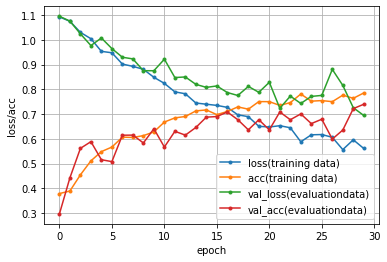

saved model..! ready to go.


In [5]:
# https://qiita.com/nirs_kd56/items/7a7330b160fd1604197e

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import numpy as np
import sys

N_CATEGORIES  = 3
IMAGE_SIZE = 224
BATCH_SIZE = 16

NUM_TRAINING = 1000
NUM_VALIDATION = 200

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_tensor=input_tensor)

# 全結合層の構築
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation("sigmoid"))
top_model.add(Dropout(0.5))
top_model.add(Dense(128))
top_model.add(Activation("sigmoid"))
top_model.add(Dense(N_CATEGORIES))
top_model.add(Activation("softmax"))

model = Model(input=base_model.input, 
              output=top_model(base_model.output))

for layer in base_model.layers:
   layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='sgd',  
              metrics=['accuracy'])

model.summary()

train_datagen = image.ImageDataGenerator(
   rescale=1.0 / 255,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   rotation_range=10)

test_datagen = image.ImageDataGenerator(
   rescale=1.0 / 255,
)

train_generator = train_datagen.flow_from_directory(
   'images/train',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
   'images/validation',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

hist = model.fit_generator(train_generator,
   steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
   epochs=30,
   verbose=1,
   validation_data=validation_generator,
   validation_steps=NUM_VALIDATION//BATCH_SIZE,
)

# 学習結果を表示
loss = hist.history['loss']
acc = hist.history['acc']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_acc']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.plot(range(epochs), acc, marker='.', label='acc(training data)')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss(evaluationdata)')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc(evaluationdata)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

# モデルを保存
model.save('fruits2.hdf5')

model_json = model.to_json()
with open('model2.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights("model2.h5")
print("saved model..! ready to go.")

In [0]:
#https://github.com/parthvadhadiya/classify_dogs-vs-cats_using_keras/blob/master/use_model.py

from keras.models import model_from_json
from keras.preprocessing import image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import numpy as np

def loadmodel(m1='model.json', m2='model.h5'):
    json_file = open(m1, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    loaded_model.load_weights(m2)
    print("Loaded model from disk")

    '''loaded_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    '''
    loaded_model.compile(optimizer = 'SGD', 
                         loss = 'categorical_crossentropy', 
                         metrics = ['accuracy'])
    return loaded_model

IMAGE_SIZE = 224

# dimensions of our images.
img_width, img_height = IMAGE_SIZE, IMAGE_SIZE

# 画像表示のための関数
def showimg(filename, title, i):
    im = ImageFile.open(filename)
    im_list = np.asarray(im)
    plt.subplot(2, 5, i)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_list)

# 画像判定のための関数
def predictimg(filename, featuresize):
    img = ImageFile.load_img(filename, target_size = (img_width, img_height))
    x = ImageFile.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    #preds = model.predict(preprocess_input(x))
    preds = model.predict(x)
    #results = decode_predictions(preds, top = featuresize)[0]
    #return results
    return preds

# 画像を判定
def predict(filename, label):
    results = predictimg(filename, 10)
    #print(results)
    index = np.argmax(results[0])
    if index == 0:
        label += ' = ' + 'apple'
    elif index == 1:
        label += ' = ' + 'strawberry'
    else:
        label += ' = ' + 'tomato'
    plt.figure(figsize = (20, 10))
    showimg(filename, label, 1)
    plt.show()

model = loadmodel('model2.json', 'model2.h5')

predict('images/validation/apple/000001.jpg', 'apple')
predict('images/validation/apple/000002.jpg', 'apple')
predict('images/validation/apple/000003.jpg', 'apple')
predict('images/validation/apple/000004.jpg', 'apple')
predict('images/validation/apple/000005.jpg', 'apple')

predict('images/validation/strawberry/000001.jpeg', 'strawberry')
predict('images/validation/strawberry/000002.jpg', 'strawberry')
predict('images/validation/strawberry/000003.jpeg', 'strawberry')
predict('images/validation/strawberry/000004.jpg', 'strawberry')
predict('images/validation/strawberry/000005.jpg', 'strawberry')

predict('images/validation/tomato/000001.jpg', 'tomato')
predict('images/validation/tomato/000002.jpg', 'tomato')
predict('images/validation/tomato/000003.jpg', 'tomato')
predict('images/validation/tomato/000004.jpg', 'tomato')
predict('images/validation/tomato/000005.png', 'tomato')


In [0]:
# https://spjai.com/keras-fine-tuning/

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import numpy as np
import sys

N_CATEGORIES  = 3
IMAGE_SIZE = 224
BATCH_SIZE = 16

NUM_TRAINING = 1000
NUM_VALIDATION = 200

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_tensor=input_tensor)

# 全結合層の構築
top_model = Sequential()
top_model.add(GlobalAveragePooling2D())
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(N_CATEGORIES, activation='softmax'))

model = Model(inputs=base_model.input, 
              outputs=top_model(base_model.output))

for layer in base_model.layers:
   layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.0001, momentum=0.9), 
              metrics=['accuracy'])

model.summary()

train_datagen = ImageFile.ImageDataGenerator(
   rescale=1.0 / 255,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   rotation_range=10)

test_datagen = ImageFile.ImageDataGenerator(
   rescale=1.0 / 255,
)

train_generator = train_datagen.flow_from_directory(
   'images/train',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
   'images/validation',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

hist = model.fit_generator(train_generator,
   steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
   epochs=30,
   verbose=1,
   validation_data=validation_generator,
   validation_steps=NUM_VALIDATION//BATCH_SIZE,
)

# 学習結果を表示
loss = hist.history['loss']
acc = hist.history['acc']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_acc']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.plot(range(epochs), acc, marker='.', label='acc(training data)')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss(evaluationdata)')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc(evaluationdata)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

# モデルを保存
model.save('fruits.hdf5')

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("saved model..! ready to go.")

In [0]:
def loadmodel(m1='model.json', m2='model.h5'):
    json_file = open(m1, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    loaded_model.load_weights(m2)
    print("Loaded model from disk")

    '''loaded_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    '''
    loaded_model.compile(optimizer = 'SGD', 
                         loss = 'categorical_crossentropy', 
                         metrics = ['accuracy'])
    return loaded_model

model = loadmodel('model.json', 'model.h5')

predict('images/validation/apple/000001.jpg', 'apple')
predict('images/validation/apple/000002.jpg', 'apple')
predict('images/validation/apple/000003.jpg', 'apple')
predict('images/validation/apple/000004.jpg', 'apple')
predict('images/validation/apple/000005.jpg', 'apple')

predict('images/validation/strawberry/000001.jpeg', 'strawberry')
predict('images/validation/strawberry/000002.jpg', 'strawberry')
predict('images/validation/strawberry/000003.jpeg', 'strawberry')
predict('images/validation/strawberry/000004.jpg', 'strawberry')
predict('images/validation/strawberry/000005.jpg', 'strawberry')

predict('images/validation/tomato/000001.jpg', 'tomato')
predict('images/validation/tomato/000002.jpg', 'tomato')
predict('images/validation/tomato/000003.jpg', 'tomato')
predict('images/validation/tomato/000004.jpg', 'tomato')
predict('images/validation/tomato/000005.png', 'tomato')
